# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the network flow dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from importlib import reload
import os
import utils, models
reload(utils)
reload(models)
from utils import model_inputs, get_flow_dataset
from models import generator, discriminator

In [3]:
(benign_train, benign_test), (attack_train, attack_test) = get_flow_dataset(os.path.join('data', 'ids2017_sampled.csv'))

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
benign_train.shape

(1500, 47)

In [5]:
benign_test.shape

(3500, 47)

In [6]:
attack_train.shape

(1650, 47)

In [7]:
attack_test.shape

(3850, 47)

## Hyperparameters

In [8]:
# Size of input flow to discriminator
input_size = benign_train.shape[1]
# Size of latent vector to generator
z_size = 2
# Sizes of hidden layers in generator and discriminator
g_hidden_size = [128, 64]
d_hidden_size = [128, 64]
# Leak factor for leaky ReLU
alpha = 0.01

## Build network

Now we're building the network from the functions defined above.

First is to get our inputs, `input_benign, input_z, input_attack_remains` from `model_inputs` using the sizes of the input and z.

Then, we'll create the generator, `generator(input_z, z_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for benign flow data and one for attack flow data. Since we want the weights to be the same for both benign and attack flow data, we need to reuse the variables. For the attack flow data, we're getting it from the output of the generator concatenated with remaining part of attack feature called `g_model`. So the benign data discriminator is `discriminator(input_benign)` while the attack discriminator is `discriminator(g_model, reuse=True)`.

In [9]:
tf.reset_default_graph()

# Create our input placeholders
input_benign, input_z, input_attack_remains = model_inputs(input_size, z_size, attack_remains_dim=input_size - z_size)

# Build the model
z_generated, g_hidden = generator(input_z, z_size, n_units=[z_size] + g_hidden_size, alpha=alpha)
g_model = tf.concat([z_generated, input_attack_remains], 1)
# g_model is the generator output concatenated with the remaining part of attack features

d_model_benign, d_logits_benign, d_hidden_benign = discriminator(input_benign,
                                                                 n_units= [input_size] + d_hidden_size,
                                                                 alpha=alpha)
d_model_attack, d_logits_attack, d_hidden_attack = discriminator(g_model,
                                                                 reuse=True,
                                                                 n_units=[input_size] + d_hidden_size,
                                                                 alpha=alpha)

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for benign and attack flows, `d_loss = d_loss_benign + d_loss_attack`. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the flows in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the benign flow logits, we'll use `d_logits_benign` which we got from the discriminator in the cell above. For the labels, we want them to be all zeros, since these are all benign flows. In TensorFlow, it looks something like `labels = tf.zeros_like(tensor)`

The discriminator loss for the attack flow data is similar. The logits are `d_logits_attack`, which we got from passing the generator output concatenated with remaing part of attack flow features to the discriminator. These attack logits are used with labels of all ones. Remember that we want the discriminator to output 0 for benign flows and 1 for attack flows, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_attack`, the attack flow logits. But, now the labels are all zeros. The generator is trying to fool the discriminator, so it wants to discriminator to output zeros for attack flows.

In [10]:
# Calculate losses
d_loss_benign = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_benign, 
                                                          labels=tf.zeros_like(d_logits_benign)))
d_loss_attack = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack, 
                                                          labels=tf.ones_like(d_logits_attack)))
d_loss = d_loss_benign + d_loss_attack

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack,
                                                     labels=tf.zeros_like(d_logits_attack)))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [11]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [12]:
from copy import deepcopy
import time

batch_size = 100
epochs = 1000
losses = []
original_flows, generated_flows, attack_scores = [], [], []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
# TODO: add outer-loop, which is test number, to see convergence trends
# TODO: modify training process - choose random 2 features and give 2 outputs randomly back
with tf.Session() as sess:
    total_start = time.time()
    sess.run(tf.global_variables_initializer())
    init_benign_test_score = sess.run(d_model_benign, feed_dict={input_benign: benign_test})
    init_attack_test_score = sess.run(d_model_benign, feed_dict={input_benign: attack_test})
    for e in range(epochs):
        start = time.time()
        np.random.shuffle(benign_train)
        np.random.shuffle(attack_train)
        original_flows.append([])
        generated_flows.append([])
        attack_scores.append([])
        for ii in range(benign_train.shape[0]//batch_size):
            batch_benign = benign_train[ii * batch_size:(ii + 1) * batch_size]
            
            batch_attack = attack_train[ii * batch_size:(ii + 1) * batch_size]
            batch_z = batch_attack[:,:z_size]
            batch_attack_remains = batch_attack[:,z_size:]
            
            if ii % 5 == 0:
                original_flow = batch_attack
                generated_flow = sess.run(g_model, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                attack_score = sess.run(d_model_attack, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                original_flows[-1].append(deepcopy(original_flow[0]))
                generated_flows[-1].append(generated_flow[0])
                attack_scores[-1].append(attack_score[0][0])
                
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_benign: batch_benign, input_z: batch_z, input_attack_remains: batch_attack_remains})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_benign: batch_benign, input_attack_remains: batch_attack_remains})
        train_loss_g = g_loss.eval({input_z: batch_z, input_attack_remains: batch_attack_remains})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g),
              "Time elapsed: {:.4f}".format(time.time() - start)
             )    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        saver.save(sess, './checkpoints/generator.ckpt')
    print('Total training time:', time.time() - total_start)
    
    final_benign_test_score = sess.run(d_model_benign, feed_dict={input_benign: benign_test})
    final_attack_test_score = sess.run(d_model_benign, feed_dict={input_benign: attack_test})

Epoch 1/1000... Discriminator Loss: 15400.1472... Generator Loss: 832744.9833 Time elapsed: 1.4573
Epoch 2/1000... Discriminator Loss: 37086.0986... Generator Loss: 5205094.9379 Time elapsed: 0.0883
Epoch 3/1000... Discriminator Loss: 50038.8449... Generator Loss: 4700452.0782 Time elapsed: 0.0770
Epoch 4/1000... Discriminator Loss: 9167.3426... Generator Loss: 4852276.0105 Time elapsed: 0.0860
Epoch 5/1000... Discriminator Loss: 35579.6471... Generator Loss: 3180640.7107 Time elapsed: 0.0758
Epoch 6/1000... Discriminator Loss: 160.4974... Generator Loss: 2097578.4028 Time elapsed: 0.0829
Epoch 7/1000... Discriminator Loss: 9601.9345... Generator Loss: 1939565.6652 Time elapsed: 0.0747
Epoch 8/1000... Discriminator Loss: 892.5181... Generator Loss: 2705233.5068 Time elapsed: 0.0829
Epoch 9/1000... Discriminator Loss: 162.5033... Generator Loss: 2602395.1990 Time elapsed: 0.0775
Epoch 10/1000... Discriminator Loss: 3267.6296... Generator Loss: 2235567.1192 Time elapsed: 0.0743
Epoch 11/

Epoch 85/1000... Discriminator Loss: 61.4527... Generator Loss: 1468752.4146 Time elapsed: 0.0689
Epoch 86/1000... Discriminator Loss: 0.0000... Generator Loss: 1685358.4188 Time elapsed: 0.0881
Epoch 87/1000... Discriminator Loss: 0.0000... Generator Loss: 919830.6042 Time elapsed: 0.0768
Epoch 88/1000... Discriminator Loss: 0.0000... Generator Loss: 1149644.2571 Time elapsed: 0.0708
Epoch 89/1000... Discriminator Loss: 0.0000... Generator Loss: 1544707.9320 Time elapsed: 0.0843
Epoch 90/1000... Discriminator Loss: 0.0000... Generator Loss: 1489058.6376 Time elapsed: 0.0800
Epoch 91/1000... Discriminator Loss: 0.0000... Generator Loss: 1413159.4422 Time elapsed: 0.0730
Epoch 92/1000... Discriminator Loss: 0.0000... Generator Loss: 1580798.1641 Time elapsed: 0.0784
Epoch 93/1000... Discriminator Loss: 0.0000... Generator Loss: 989360.7298 Time elapsed: 0.0842
Epoch 94/1000... Discriminator Loss: 0.0000... Generator Loss: 1076251.2076 Time elapsed: 0.0666
Epoch 95/1000... Discriminator 

Epoch 169/1000... Discriminator Loss: 3284.7018... Generator Loss: 1067063.8146 Time elapsed: 0.0842
Epoch 170/1000... Discriminator Loss: 0.0000... Generator Loss: 1041472.2321 Time elapsed: 0.0857
Epoch 171/1000... Discriminator Loss: 0.0000... Generator Loss: 712698.9372 Time elapsed: 0.0881
Epoch 172/1000... Discriminator Loss: 0.0000... Generator Loss: 766580.7486 Time elapsed: 0.0877
Epoch 173/1000... Discriminator Loss: 26.6088... Generator Loss: 493902.8704 Time elapsed: 0.0798
Epoch 174/1000... Discriminator Loss: 0.0000... Generator Loss: 735812.0526 Time elapsed: 0.0763
Epoch 175/1000... Discriminator Loss: 0.0000... Generator Loss: 810242.4611 Time elapsed: 0.0799
Epoch 176/1000... Discriminator Loss: 119.8545... Generator Loss: 865719.7321 Time elapsed: 0.0821
Epoch 177/1000... Discriminator Loss: 0.0000... Generator Loss: 717753.9254 Time elapsed: 0.0719
Epoch 178/1000... Discriminator Loss: 0.0000... Generator Loss: 800245.7743 Time elapsed: 0.0815
Epoch 179/1000... Disc

Epoch 253/1000... Discriminator Loss: 0.0000... Generator Loss: 566886.5878 Time elapsed: 0.0841
Epoch 254/1000... Discriminator Loss: 14.5641... Generator Loss: 911471.0850 Time elapsed: 0.0726
Epoch 255/1000... Discriminator Loss: 0.0000... Generator Loss: 818847.2712 Time elapsed: 0.0795
Epoch 256/1000... Discriminator Loss: 0.0000... Generator Loss: 708555.2284 Time elapsed: 0.0754
Epoch 257/1000... Discriminator Loss: 0.0000... Generator Loss: 738890.0508 Time elapsed: 0.0796
Epoch 258/1000... Discriminator Loss: 0.0000... Generator Loss: 525938.5269 Time elapsed: 0.0787
Epoch 259/1000... Discriminator Loss: 37.4142... Generator Loss: 898595.5121 Time elapsed: 0.0816
Epoch 260/1000... Discriminator Loss: 0.0000... Generator Loss: 980354.0939 Time elapsed: 0.0872
Epoch 261/1000... Discriminator Loss: 59.3750... Generator Loss: 2341224.9921 Time elapsed: 0.0778
Epoch 262/1000... Discriminator Loss: 0.9547... Generator Loss: 1943780.2568 Time elapsed: 0.0822
Epoch 263/1000... Discrim

Epoch 337/1000... Discriminator Loss: 75.2822... Generator Loss: 445061.6757 Time elapsed: 0.0785
Epoch 338/1000... Discriminator Loss: 2.7317... Generator Loss: 1140924.4303 Time elapsed: 0.0757
Epoch 339/1000... Discriminator Loss: 0.0000... Generator Loss: 592968.4285 Time elapsed: 0.0765
Epoch 340/1000... Discriminator Loss: 10.0603... Generator Loss: 599286.2637 Time elapsed: 0.0770
Epoch 341/1000... Discriminator Loss: 30.9312... Generator Loss: 740799.3220 Time elapsed: 0.0712
Epoch 342/1000... Discriminator Loss: 1746.4163... Generator Loss: 867461.9418 Time elapsed: 0.0769
Epoch 343/1000... Discriminator Loss: 0.0000... Generator Loss: 521931.1999 Time elapsed: 0.0909
Epoch 344/1000... Discriminator Loss: 0.0000... Generator Loss: 568216.4814 Time elapsed: 0.0829
Epoch 345/1000... Discriminator Loss: 0.0000... Generator Loss: 542546.9826 Time elapsed: 0.0880
Epoch 346/1000... Discriminator Loss: 9.3520... Generator Loss: 1546078.9602 Time elapsed: 0.0853
Epoch 347/1000... Disc

Epoch 421/1000... Discriminator Loss: 0.0000... Generator Loss: 489410.7546 Time elapsed: 0.0883
Epoch 422/1000... Discriminator Loss: 0.0000... Generator Loss: 914639.4272 Time elapsed: 0.0815
Epoch 423/1000... Discriminator Loss: 206.6560... Generator Loss: 370302.2269 Time elapsed: 0.0766
Epoch 424/1000... Discriminator Loss: 99.4511... Generator Loss: 560677.0939 Time elapsed: 0.0775
Epoch 425/1000... Discriminator Loss: 0.0000... Generator Loss: 441555.1049 Time elapsed: 0.0838
Epoch 426/1000... Discriminator Loss: 0.0000... Generator Loss: 1074810.4426 Time elapsed: 0.0812
Epoch 427/1000... Discriminator Loss: 0.0000... Generator Loss: 937080.4471 Time elapsed: 0.0855
Epoch 428/1000... Discriminator Loss: 0.0000... Generator Loss: 743875.9829 Time elapsed: 0.0729
Epoch 429/1000... Discriminator Loss: 0.0000... Generator Loss: 620733.8781 Time elapsed: 0.0917
Epoch 430/1000... Discriminator Loss: 0.0000... Generator Loss: 497834.0597 Time elapsed: 0.0830
Epoch 431/1000... Discrimi

Epoch 507/1000... Discriminator Loss: 13.9095... Generator Loss: 432798.8999 Time elapsed: 0.0684
Epoch 508/1000... Discriminator Loss: 172.0246... Generator Loss: 531718.5729 Time elapsed: 0.0839
Epoch 509/1000... Discriminator Loss: 0.0000... Generator Loss: 779998.8043 Time elapsed: 0.0781
Epoch 510/1000... Discriminator Loss: 0.0000... Generator Loss: 453687.2285 Time elapsed: 0.0821
Epoch 511/1000... Discriminator Loss: 0.0000... Generator Loss: 723003.2121 Time elapsed: 0.0952
Epoch 512/1000... Discriminator Loss: 0.0000... Generator Loss: 314309.8967 Time elapsed: 0.0935
Epoch 513/1000... Discriminator Loss: 75.8891... Generator Loss: 432777.8780 Time elapsed: 0.0902
Epoch 514/1000... Discriminator Loss: 95.2387... Generator Loss: 469268.4264 Time elapsed: 0.0803
Epoch 515/1000... Discriminator Loss: 0.0000... Generator Loss: 414599.4030 Time elapsed: 0.0747
Epoch 516/1000... Discriminator Loss: 0.0000... Generator Loss: 673826.1969 Time elapsed: 0.0924
Epoch 517/1000... Discrim

Epoch 593/1000... Discriminator Loss: 42.2352... Generator Loss: 1407189.7984 Time elapsed: 0.0822
Epoch 594/1000... Discriminator Loss: 0.0000... Generator Loss: 1401127.5412 Time elapsed: 0.0824
Epoch 595/1000... Discriminator Loss: 0.0000... Generator Loss: 1421524.6252 Time elapsed: 0.0979
Epoch 596/1000... Discriminator Loss: 1002.4638... Generator Loss: 1237344.7288 Time elapsed: 0.1057
Epoch 597/1000... Discriminator Loss: 0.0000... Generator Loss: 936850.6938 Time elapsed: 0.1006
Epoch 598/1000... Discriminator Loss: 0.0000... Generator Loss: 1017354.0127 Time elapsed: 0.0924
Epoch 599/1000... Discriminator Loss: 123.5972... Generator Loss: 1170751.9026 Time elapsed: 0.0876
Epoch 600/1000... Discriminator Loss: 1356.4366... Generator Loss: 1442081.8050 Time elapsed: 0.0930
Epoch 601/1000... Discriminator Loss: 127.9201... Generator Loss: 1145286.3108 Time elapsed: 0.0922
Epoch 602/1000... Discriminator Loss: 493.0957... Generator Loss: 1579108.1342 Time elapsed: 0.0990
Epoch 60

Epoch 678/1000... Discriminator Loss: 60.5348... Generator Loss: 751498.2624 Time elapsed: 0.0894
Epoch 679/1000... Discriminator Loss: 33.9616... Generator Loss: 621612.1520 Time elapsed: 0.0889
Epoch 680/1000... Discriminator Loss: 0.0000... Generator Loss: 643965.2106 Time elapsed: 0.0829
Epoch 681/1000... Discriminator Loss: 0.0000... Generator Loss: 610631.3078 Time elapsed: 0.0845
Epoch 682/1000... Discriminator Loss: 26.3532... Generator Loss: 849035.3064 Time elapsed: 0.0964
Epoch 683/1000... Discriminator Loss: 0.0000... Generator Loss: 849575.1749 Time elapsed: 0.0960
Epoch 684/1000... Discriminator Loss: 13.8059... Generator Loss: 607430.1895 Time elapsed: 0.0894
Epoch 685/1000... Discriminator Loss: 0.0000... Generator Loss: 563057.6943 Time elapsed: 0.1035
Epoch 686/1000... Discriminator Loss: 8.0524... Generator Loss: 990321.5454 Time elapsed: 0.0837
Epoch 687/1000... Discriminator Loss: 35.8199... Generator Loss: 655614.6348 Time elapsed: 0.0971
Epoch 688/1000... Discrim

Epoch 763/1000... Discriminator Loss: 0.0000... Generator Loss: 569147.3528 Time elapsed: 0.1062
Epoch 764/1000... Discriminator Loss: 0.0000... Generator Loss: 538032.7086 Time elapsed: 0.0949
Epoch 765/1000... Discriminator Loss: 0.0000... Generator Loss: 561926.1728 Time elapsed: 0.0810
Epoch 766/1000... Discriminator Loss: 0.0000... Generator Loss: 403703.1951 Time elapsed: 0.0865
Epoch 767/1000... Discriminator Loss: 0.0000... Generator Loss: 361749.2788 Time elapsed: 0.0856
Epoch 768/1000... Discriminator Loss: 0.0000... Generator Loss: 561842.6816 Time elapsed: 0.0878
Epoch 769/1000... Discriminator Loss: 0.0000... Generator Loss: 637951.1741 Time elapsed: 0.0869
Epoch 770/1000... Discriminator Loss: 0.5401... Generator Loss: 327216.5759 Time elapsed: 0.0767
Epoch 771/1000... Discriminator Loss: 0.0000... Generator Loss: 413044.9057 Time elapsed: 0.0896
Epoch 772/1000... Discriminator Loss: 0.0000... Generator Loss: 374747.8142 Time elapsed: 0.0936
Epoch 773/1000... Discriminato

Epoch 849/1000... Discriminator Loss: 0.0000... Generator Loss: 321725.1080 Time elapsed: 0.0883
Epoch 850/1000... Discriminator Loss: 0.0000... Generator Loss: 244272.4378 Time elapsed: 0.0840
Epoch 851/1000... Discriminator Loss: 0.0000... Generator Loss: 264301.0607 Time elapsed: 0.0863
Epoch 852/1000... Discriminator Loss: 0.0000... Generator Loss: 318010.5004 Time elapsed: 0.0921
Epoch 853/1000... Discriminator Loss: 0.0000... Generator Loss: 182286.0498 Time elapsed: 0.0838
Epoch 854/1000... Discriminator Loss: 0.0000... Generator Loss: 259642.7423 Time elapsed: 0.0859
Epoch 855/1000... Discriminator Loss: 0.0000... Generator Loss: 259466.4553 Time elapsed: 0.0970
Epoch 856/1000... Discriminator Loss: 0.0000... Generator Loss: 340994.4511 Time elapsed: 0.0874
Epoch 857/1000... Discriminator Loss: 0.0000... Generator Loss: 275039.8274 Time elapsed: 0.0879
Epoch 858/1000... Discriminator Loss: 0.0000... Generator Loss: 203773.1907 Time elapsed: 0.0913
Epoch 859/1000... Discriminato

Epoch 934/1000... Discriminator Loss: 0.0000... Generator Loss: 310381.2102 Time elapsed: 0.0901
Epoch 935/1000... Discriminator Loss: 0.0000... Generator Loss: 345657.4616 Time elapsed: 0.0911
Epoch 936/1000... Discriminator Loss: 0.0000... Generator Loss: 232656.7581 Time elapsed: 0.0981
Epoch 937/1000... Discriminator Loss: 0.0000... Generator Loss: 357897.2699 Time elapsed: 0.0824
Epoch 938/1000... Discriminator Loss: 0.0000... Generator Loss: 390256.7409 Time elapsed: 0.0859
Epoch 939/1000... Discriminator Loss: 0.0000... Generator Loss: 331484.4515 Time elapsed: 0.1006
Epoch 940/1000... Discriminator Loss: 0.0000... Generator Loss: 255884.4211 Time elapsed: 0.0938
Epoch 941/1000... Discriminator Loss: 0.0000... Generator Loss: 231269.4703 Time elapsed: 0.0761
Epoch 942/1000... Discriminator Loss: 0.0000... Generator Loss: 403407.8789 Time elapsed: 0.0879
Epoch 943/1000... Discriminator Loss: 0.0000... Generator Loss: 296623.9542 Time elapsed: 0.0917
Epoch 944/1000... Discriminato

## Training loss

Here we'll check out the training losses for the generator and discriminator.

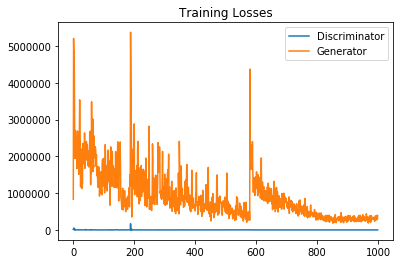

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Test Part

In [14]:
# TODO: test if discriminator is fooled

In [15]:
print('Accuracy before training')
print('Discriminator benign test accuracy:', (init_benign_test_score <= 0.5).sum() / benign_test.shape[0])
print('Discriminator attack test accuracy:', (init_attack_test_score > 0.5).sum() / attack_test.shape[0])
print('Discriminator total test accuracy:',
      ((init_benign_test_score <= 0.5).sum() + (init_attack_test_score > 0.5).sum()) / (benign_test.shape[0] + attack_test.shape[0]))

Accuracy before training
Discriminator benign test accuracy: 0.3271428571428571
Discriminator attack test accuracy: 0.4176623376623377
Discriminator total test accuracy: 0.3745578231292517


In [16]:
print('Accuracy after training')
print('Discriminator benign test accuracy:', (final_benign_test_score <= 0.5).sum() / benign_test.shape[0])
print('Discriminator attack test accuracy:', (final_attack_test_score > 0.5).sum() / attack_test.shape[0])
print('Discriminator total test accuracy:',
      ((final_benign_test_score <= 0.5).sum() + (final_attack_test_score > 0.5).sum()) / (benign_test.shape[0] + attack_test.shape[0]))

Accuracy after training
Discriminator benign test accuracy: 0.996
Discriminator attack test accuracy: 0.7553246753246753
Discriminator total test accuracy: 0.8699319727891156


# Output Visualization

In [17]:
import math

def split_to_two_nearest_factor(x):
    sqrt_x = int(math.sqrt(x))
    i = sqrt_x
    while x % i != 0:
        i -= 1
    return (i, x // i)
fig_size = split_to_two_nearest_factor(input_size)
import numpy as np
import matplotlib.pyplot as plt

fooled = 0

# fig=plt.figure(figsize=(fig_size[0] * 5, fig_size[1] * 5))
# columns = 2
rows = len(original_flows)
for i in range(rows):
#     original_img = original_flows[i][0]
#     generated_img = generated_flows[i][0]
#     ax_original = fig.add_subplot(rows, columns, i * 2 + 1)
#     ax_original.set_title('Epoch {epoch}'.format(epoch=i + 1))
#     plt.imshow(original_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
#     ax_generated = fig.add_subplot(rows, columns, i * 2 + 2)
#     plt.imshow(generated_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
    if attack_scores[i][0] <= 0.5:
#         ax_generated.set_title('Fooled:' + str(attack_scores[i][0]))
        fooled += 1
#     else:
#         ax_generated.set_title('Just close:' + str(attack_scores[i][0]))
# plt.show()
print('Fooled rate:', fooled / len(original_flows))

Fooled rate: 0.007


# Generate attack flows

In [18]:
#TODO: generate attack flows for Kaihua's discrimination